In [1]:
# Імпортуємо необхідні бібліотеки
import os
import re

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

# Встановлюємо стиль для графіків Seaborn:
sns.set_theme(style="whitegrid")

## Data


Variable | Definition                                 | Key                            |
---------|--------------------------------------------|--------------------------------|
survival | Survival                                   | 0 = No, 1 = Yes                |
pclass	 | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd      |
sex      | Sex                                        |                                |
Age      | Age in years	                              |                                |
sibsp    | № of siblings / spouses aboard the Titanic |                                |
parch	 | № of parents / children aboard the Titanic |                                |
ticket   | Ticket number                              |                                |
fare     | Passenger fare                             |                                | 	
cabin    | Cabin number	                              |
embarked | Port of Embarkation	                      | C = Cherbourg, Q = Queenstown, S = Southampton |


In [2]:
# Завантажуємо навчальний датасет "train.csv" та виводимо його розмір та перші декілька рядків:
train = pd.read_csv(os.path.join("data", "train.csv"))
print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Завантажуємо тестовий датасет "test.csv" та виводимо його розмір та перші декілька рядків:
test = pd.read_csv(os.path.join("data", "test.csv"))
print(test.shape)
test.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Data analysis

Цей код виконує попередню обробку даних (feature engineering) для датасету Kaggle Titanic, з метою підготовки даних до подальшої аналізу та моделювання для передбачення виживання пасажирів на Титаніку.

In [4]:
# Виводимо описову статистику для навчального датасету "train"
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
# Виводимо інформацію про типи даних та наявність пропущених значень в навчальному та тестовому датасетах:
print(train.info())
print()
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pc

In [6]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [7]:
# Визначаємо змінні для ідентифікації, категоріальних ознак, числових ознак та цільової змінної:
id_feature = "PassengerId"
categorical_features = ["Sex", "Ticket", "Cabin", "Embarked", "Pclass"]
continuous_features = ["Age", "Fare", "SibSp", "Parch"]
target_feature = "Survived"

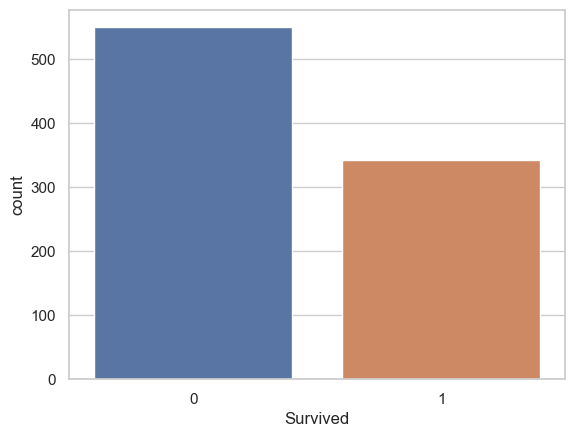

In [8]:
sns.countplot(train, x="Survived");

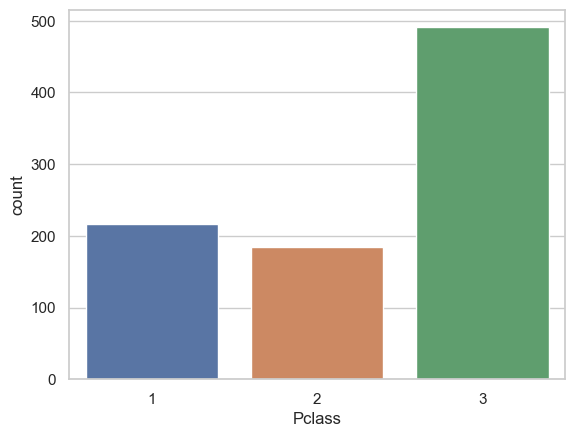

In [9]:
# Побудова гістограми для залежності виживання від класу пасажира
sns.countplot(train, x="Pclass");

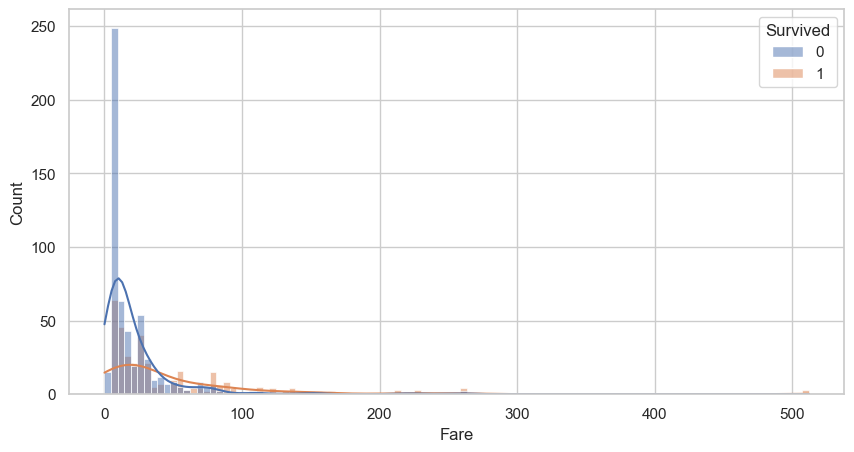

In [10]:
# Побудова гістограми для розподілу вартості квитка в залежності від виживання
fix, ax = plt.subplots(figsize=(10, 5))
sns.histplot(train, x="Fare", hue="Survived", kde=True, ax=ax);

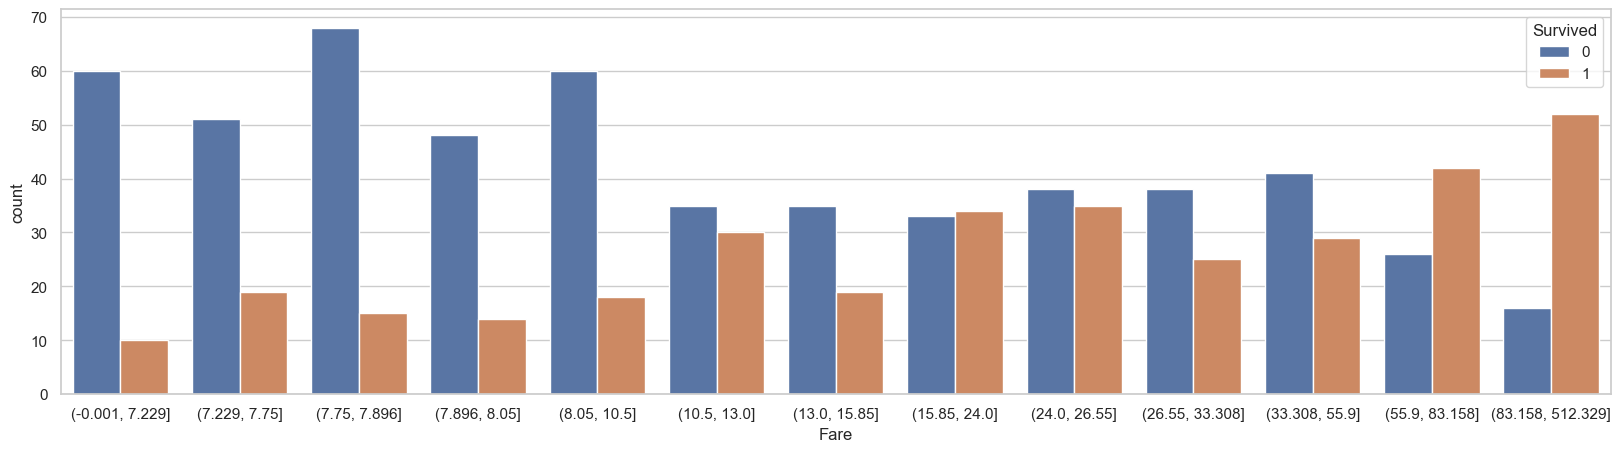

In [11]:
# Побудова гістограми для розподілу вартості квитка, розділеного на 13 кількісних діапазонів (категоріальних ознак) в залежності від виживання
fix, ax = plt.subplots(figsize=(20, 5))
tmp = train.copy()
tmp["Fare"] = pd.qcut(tmp["Fare"], 13)
sns.countplot(tmp, x="Fare", hue="Survived");

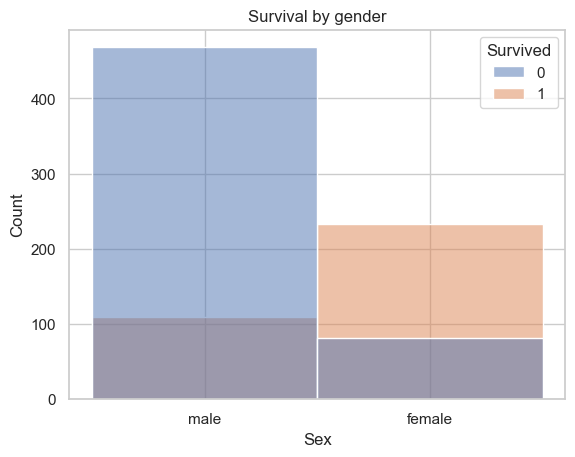

In [12]:
# Побудова гістограм для залежності виживання від статі
plt.title("Survival by gender")
sns.histplot(data=train, hue="Survived", x="Sex");

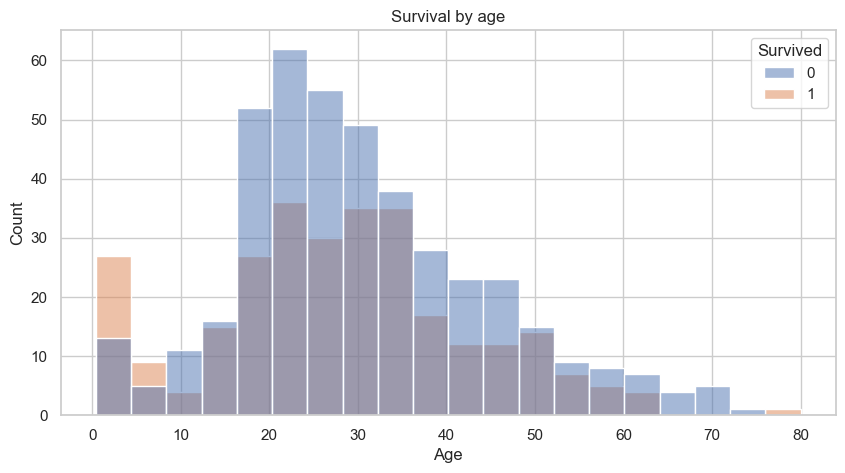

In [13]:
# Побудова гістограм для залежності виживання від віку
plt.figure(figsize=(10, 5))
plt.title("Survival by age")
sns.histplot(data=train, hue="Survived", x="Age");

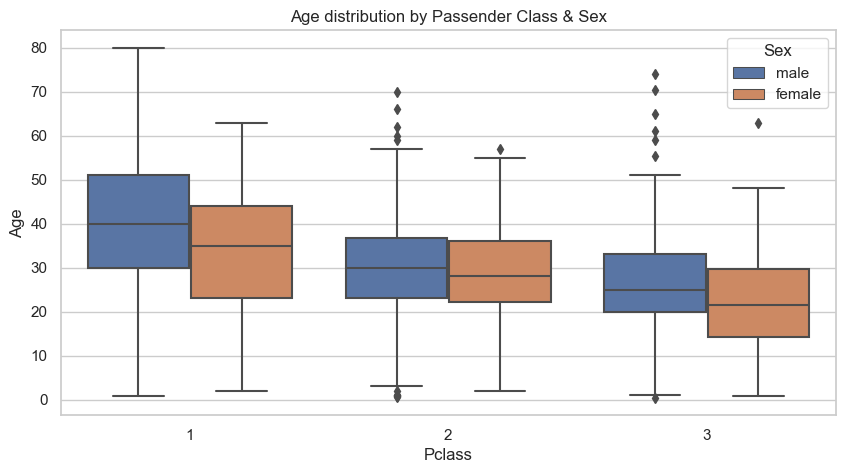

In [14]:
# Побудова бокс-плоту для розподілу віку в залежності від класу пасажира та статі
fix, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Age distribution by Passender Class & Sex")
sns.boxplot(train, x="Pclass", y="Age", hue="Sex", ax=ax);

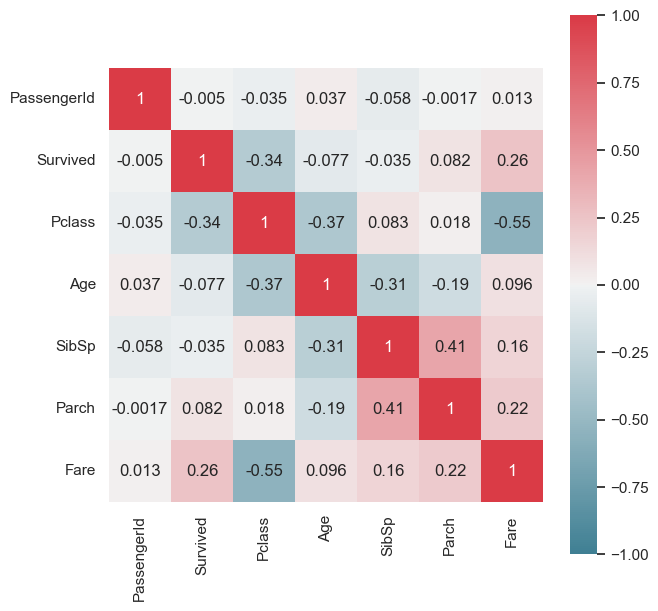

In [15]:
# Розрахунок кореляційної матриці між числовими ознаками
corr = train.corr(method="pearson", numeric_only=True)

# Побудова теплової карти для візуалізації кореляції між числовими ознаками
f, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), vmin=-1.0, vmax=1.0, square=True, ax=ax, annot=True);

### Feature engineering

In [16]:
# Об'єднання навчального і тестового датасетів у єдиний датасет dataset, з відновленням індексів:
dataset = pd.concat([train, test]).reset_index(drop=True)

# Виведення інформації про типи даних та наявність пропущених значень в об'єднаному датасеті:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [17]:
# dataset["Title"] = [re.findall(r"\S+(?=\.)", name)[0] for name in dataset["Name"]]
# dataset["Age"] = dataset["Age"].fillna(dataset.groupby("Title")["Age"].transform("mean"))
# dataset["AgeRounded"] = dataset["Age"].apply(lambda x: round(x/10)*10)  # remove decimal part
# dataset["NumFamily"] = 1 + dataset["SibSp"] + dataset["Parch"]  # person + number of siblings + number of parrents

# print(dataset["Title"].unique())

Meanings:

    Mr - any man
    Mrs - married woman who uses her husband's last name
    Miss -  unmarried woman
    Ms - married or unmarried woman (common in business)
    Master - minor male
    Don - male that around 40s
    Dona - female that around 40s
    Sir - adult male of any age
    Lady - adult female of any age
    Dr - Doctor
    Rev - Reverend
    Mme - Madame
    Mlle - Mademoiselle
    Major - Rank in the Military
    Col - Colonel
    Capt - Captain
    Countess - Wife of a Count
    Jonkheer - a rank for nobility

In [18]:
# Створення нової ознаки "Family_Size" яка представляє собою кількість членів сім'ї на борту.
# Ця ознака обчислюється як сума "1 + SibSp + Parch", де SibSp - кількість братів і сестер або подружніх, а Parch - кількість батьків або дітей:
dataset["Family_Size"] = 1 + dataset["SibSp"] + dataset["Parch"]  # person + number of siblings + number of parrents

# Створення категоріальної ознаки "Family_Size_Grouped", яка групує розмір сім'ї на кілька категорій,
# відповідно до кількості членів сім'ї. Групи задані словником "family_map":
family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
dataset["Family_Size_Grouped"] = dataset["Family_Size"].map(family_map)

# Визначення медіани віку для кожного класу пасажира та статі. 
# Ця інформація буде використовуватися для заповнення пропущених значень в стовпці "Age". 
# Також, виводиться медіанний вік усіх пасажирів:
age_by_pclass_sex = dataset.groupby(["Sex", "Pclass"])["Age"].median()
for pclass in range(1, 4):
    for sex in ["female", "male"]:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(dataset["Age"].median()))

# Заміна пропущених значень в стовпці "Age" на медіанний вік відповідно до статі і класу пасажира:
dataset["Age"] = dataset[["Sex", "Pclass", "Age"]].apply(lambda x: age_by_pclass_sex[x["Sex"]][x["Pclass"]] if np.isnan(x["Age"]) else x["Age"], axis=1)

# Створення нової ознаки "AgeRounded", яка округлює вік до десятих:
dataset["AgeRounded"] = dataset["Age"].apply(lambda x: round(x/10)*10)  # remove decimal part

# Обчислення медіанної ціни квитка для пасажирів 3-го класу без батьків/дітей і братів/сестер, 
# та заміна пропущених значень ціни квитка на цю медіанну вартість:
med_fare = dataset.groupby(["Pclass", "Parch", "SibSp"])["Fare"].median()[3][0][0]
print("Median fare:", med_fare)
dataset["Fare"] = dataset['Fare'].fillna(med_fare)

# Створення нової ознаки "Ticket_Frequency", яка показує, скільки разів зустрічається квиток у датасеті. 
# Ця ознака може вказувати на те, скільки пасажирів подорожували по ціні одного і того самого ж квитка:
dataset["Ticket_Frequency"] = dataset.groupby("Ticket")["Ticket"].transform("count")

# Створення ознаки "Title", яка витягує з імен пасажирів їхній заголовок (наприклад, "Mr.", "Mrs.", "Miss"):
dataset["Title"] = dataset["Name"].str.split(", ", expand=True)[1].str.split('.', expand=True)[0]

# Створення ознаки "Is_Married", яка вказує, чи пасажир є одруженим ("1" - якщо "Title" рівний "Mrs", інакше "0"):
dataset["Is_Married"] = 0
dataset.loc[dataset["Title"] == "Mrs", "Is_Married"] = 1

Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0
Median fare: 7.8542


Цей код виконує ряд операцій для обробки та підготовки даних, щоб покращити якість та коректність подальшого аналізу та моделювання в рамках задачі передбачення виживання на Титаніку.

In [19]:
# dataset[dataset["Fare"].isnull()]

In [20]:
# tomsfare = dataset.groupby(["Pclass", "Sex", "AgeRounded"])["Fare"].mean()[3, "male", 60]
# print("Avarage Fare of a male from pclass 3 and around 60th is : " + str(tomsfare))
# dataset["Fare"].fillna(tomsfare, inplace=True)

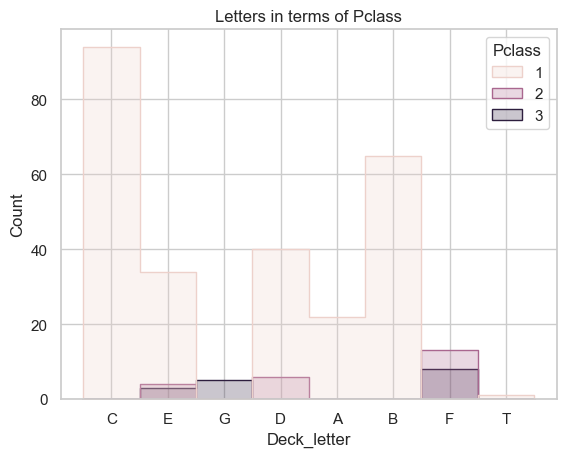

In [21]:
# Створення ознаки "Deck_letter" на основі інформації про кабіни пасажирів. 
# Вона містить першу літеру з інформації про кабіни. При цьому враховуються тільки записи з не нульовим значенням в стовпці "Cabin":
dataset.loc[dataset["Cabin"].notnull(), "Deck_letter"] = [i.split(" ")[0][0] for i in dataset.loc[dataset["Cabin"].notnull(), "Cabin"].tolist()]

# Візуалізація розподілу літер кабін в залежності від класу пасажирів. 
# Гістограма демонструє, як літери кабін розподілені за різними класами:
sns.histplot(data=dataset, x="Deck_letter", hue="Pclass", element="step")
plt.title("Letters in terms of Pclass");

In [22]:
# Перевірка наявності літери "T" у кабінах і заміна її найбільш поширеною літерою, "C":
dataset.loc[dataset["Deck_letter"] == "T"]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Family_Size_Grouped,AgeRounded,Ticket_Frequency,Title,Is_Married,Deck_letter
339,340,0.0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5,T,S,1,Alone,40,1,Mr,0,T


In [23]:
# replace it with most common
dataset["Deck_letter"] = dataset["Deck_letter"].replace("T", "C")

Text(0.5, 1.0, 'Letter values of test data ')

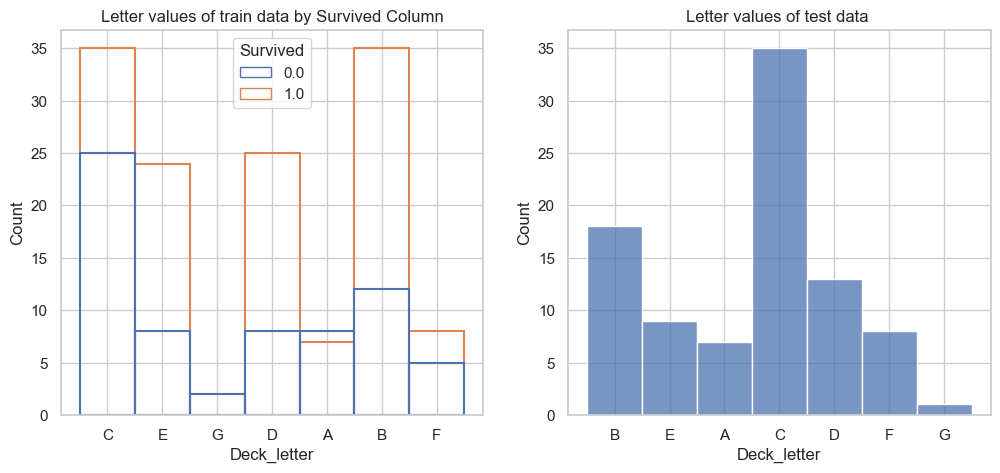

In [24]:
# Графіки розподілу літер кабін для навчального та тестового датасетів з відображенням виживших та невиживших пасажирів:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# NOTE: useing train data
sns.histplot(data=dataset.iloc[:891,], x="Deck_letter", hue="Survived", fill=False, ax=axs[0], bins=30)  
axs[0].set_title("Letter values of train data by Survived Column")

# Create a box plot on the second subplot
sns.histplot(x="Deck_letter", data=dataset.iloc[891:,], ax=axs[1], bins=30)
axs[1].set_title("Letter values of test data ")

All G Passengers died. It is probably that it has hierarchical system. I mean that A Passengers are more rich than others so the best locations on the ship are own by A Passengers.

G Passengers has the worst place in ship so they probably could not run from being drowned.

In [25]:
# Заповнення пропущених значень в ознакі "Deck_letter" значенням "U" (Unknown) і видалення стовпця "Cabin":
dataset["Deck_letter"] = dataset["Deck_letter"].fillna("U")
dataset.drop("Cabin", axis=1, inplace=True)

In [26]:
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Family_Size,Family_Size_Grouped,AgeRounded,Ticket_Frequency,Title,Is_Married,Deck_letter
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,2,Small,20,1,Mr,0,U
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,2,Small,40,2,Mrs,1,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1,Alone,30,1,Miss,0,U
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,2,Small,40,2,Mrs,1,C
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1,Alone,40,1,Mr,0,U


In [27]:
# Заміна пропущених значень в ознакі "Embarked" на "S" (Southampton) та перевірка наявності дублікатів в датасеті:
dataset["Embarked"] = dataset["Embarked"].fillna("S")

In [28]:
dataset.isnull().sum()

PassengerId              0
Survived               418
Pclass                   0
Name                     0
Sex                      0
Age                      0
SibSp                    0
Parch                    0
Ticket                   0
Fare                     0
Embarked                 0
Family_Size              0
Family_Size_Grouped      0
AgeRounded               0
Ticket_Frequency         0
Title                    0
Is_Married               0
Deck_letter              0
dtype: int64

In [29]:
dataset[dataset.duplicated(subset=["Name"])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Family_Size,Family_Size_Grouped,AgeRounded,Ticket_Frequency,Title,Is_Married,Deck_letter
891,892,NaN,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,1,Alone,30,1,Mr,0,U
897,898,NaN,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,Q,1,Alone,30,1,Miss,0,U


In [30]:
# Вивід деяких записів, що містять однакові імена пасажирів:
dataset[(dataset["Name"] == "Kelly, Mr. James") | (dataset["Name"] == "Connolly, Miss. Kate")]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Family_Size,Family_Size_Grouped,AgeRounded,Ticket_Frequency,Title,Is_Married,Deck_letter
289,290,1.0,3,"Connolly, Miss. Kate",female,22.0,0,0,370373,7.7500,Q,1,Alone,20,1,Miss,0,U
696,697,0.0,3,"Kelly, Mr. James",male,44.0,0,0,363592,8.0500,S,1,Alone,40,1,Mr,0,U
891,892,NaN,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,1,Alone,30,1,Mr,0,U
897,898,NaN,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,Q,1,Alone,30,1,Miss,0,U


In [31]:
# Підготовка остаточного обробленого датасету processed_dataset, 
# який включає в себе кодування категоріальних ознак та видалення непотрібних ознак:
processed_dataset = dataset.drop(columns=["Name", "Title", "PassengerId", "Ticket", "Deck_letter"])
processed_dataset = pd.get_dummies(processed_dataset, drop_first=True)
for col in processed_dataset.columns[processed_dataset.dtypes == "bool"]:
    processed_dataset[col] = processed_dataset[col].astype(int)
processed_dataset.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Family_Size,AgeRounded,Ticket_Frequency,Is_Married,Sex_male,Embarked_Q,Embarked_S,Family_Size_Grouped_Large,Family_Size_Grouped_Medium,Family_Size_Grouped_Small
0,0.0,3,22.0,1,0,7.2500,2,20,1,0,1,0,1,0,0,1
1,1.0,1,38.0,1,0,71.2833,2,40,2,1,0,0,0,0,0,1
2,1.0,3,26.0,0,0,7.9250,1,30,1,0,0,0,1,0,0,0
3,1.0,1,35.0,1,0,53.1000,2,40,2,1,0,0,1,0,0,1
4,0.0,3,35.0,0,0,8.0500,1,40,1,0,1,0,1,0,0,0


In [32]:
# Розділення датасету на навчальну та тестову вибірки:
train = processed_dataset.loc[processed_dataset["Survived"].notnull(), :]
test = processed_dataset.loc[processed_dataset["Survived"].isnull(), :]

print(train.shape, test.shape)

(891, 16) (418, 16)


In [33]:
# Визначення ознак для тренування моделі:
training_features = [col for col in train.columns if col != target_feature]
training_features

['Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Family_Size',
 'AgeRounded',
 'Ticket_Frequency',
 'Is_Married',
 'Sex_male',
 'Embarked_Q',
 'Embarked_S',
 'Family_Size_Grouped_Large',
 'Family_Size_Grouped_Medium',
 'Family_Size_Grouped_Small']

In [34]:
# Створення масивів X та y для тренування моделі та масиву X_test для тестування моделі:
X = train[training_features].values
y = train[target_feature].values

X.shape, y.shape

((891, 15), (891,))

In [35]:
X_test = test[training_features].values

Цей код виконує останні операції підготовки даних для моделювання та передбачення виживання пасажирів на Титаніку.


***StratifiedKFold*** - це метод перехресної перевірки (cross-validation) в машинному навчанні, який комбінує стратифікацію з K-fold перехресною перевіркою для кращої оцінки моделей, особливо в тих випадках, коли у вас є набір даних з нерівномірною розподіленістю класів.

In [36]:
# Створення змінної "stratification", яка буде використовуватися для стратифікованого розбиття навчального датасету на фолди.
# Ця змінна об'єднує інформацію про цільову змінну, стать пасажира та літеру кабіни для навчального датасету:
stratification = (
    train[target_feature].astype(str) + "_" +
    # dataset.loc[dataset["Survived"].notnull(), "Sex"] + "_" +
    dataset.loc[dataset["Survived"].notnull(), "Deck_letter"]
)

# Ініціалізація змінних scores та oof_predictions для зберігання результатів оцінки моделі та прогнозів на тестовому наборі даних, а також визначення кількості фолдів:
scores = []
oof_predictions = []
n_folds = 5

# Запуск циклу для кожного фолду в стратифікованому навчальному датасеті з використанням StratifiedKFold. Для кожного фолду відбувається наступне:
# Розділення даних на тренувальний та валідаційний набори.
# Ініціалізація та навчання моделі LogisticRegression на тренувальних даних.
# Здійснення передбачень на валідаційних даних та обчислення точності (accuracy) передбачень.
# Зберігання точності в списку scores.
# Здійснення передбачень моделі на тестовому наборі даних та зберігання їх в oof_predictions.
for f_idx, (t_idx, v_idx) in enumerate(StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42).split(X, stratification)):
    print(f"Fold {f_idx+1}/{n_folds}")

    x_train = X[t_idx]
    y_train = y[t_idx]

    x_valid = X[v_idx]
    y_valid = y[v_idx]
    
    model = LogisticRegression(max_iter=10_000).fit(x_train, y_train)
    y_preds = model.predict(x_valid)
    val_score = np.mean(y_preds == y_valid)
    print("  Accuracy:", val_score)
    scores.append(val_score)

    oof_predictions.append(model.predict_proba(X_test))

# Виведення середнього значення точності (accuracy) та стандартного відхилення точності для всіх фолдів:
print("\nScore estimation:", np.mean(scores), "+-", np.std(scores))

Fold 1/5
  Accuracy: 0.8100558659217877
Fold 2/5


/Users/dimdoroshenko/miniconda3/envs/hillel/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


  Accuracy: 0.8258426966292135
Fold 3/5
  Accuracy: 0.8089887640449438
Fold 4/5
  Accuracy: 0.7921348314606742
Fold 5/5
  Accuracy: 0.8370786516853933

Score estimation: 0.8148201619484026 +- 0.015415995417984149


Цей код виконує крос-валідацію для моделі LogisticRegression з використанням стратифікації та обчислює середню точність для оцінки якості моделі на навчальному наборі даних.

In [37]:
submission_df = dataset.loc[dataset["Survived"].isnull(), ["PassengerId"]]
submission_df[target_feature] = np.array(oof_predictions).mean(0).argmax(1)  # [folds, N, 2] -> [N, 2] -> [N
submission_df.to_csv("submission.csv", index=False)

In [38]:
submission_df[submission_df["PassengerId"].isin([892, 898])]

,PassengerId,Survived
891,892,0
897,898,1


In [39]:
# # Kelly, Mr. James
# submission_df.loc[submission_df["PassengerId"] == 892, target_feature] = 0
# # Connolly, Miss. Kate
# submission_df.loc[submission_df["PassengerId"] == 898, target_feature] = 1
# submission_df.to_csv("submission_leak.csv", index=False)

In [40]:
# model = LogisticRegression(max_iter=10_000).fit(X, y)
# submission_df = dataset.loc[dataset["Survived"].isnull(), ["PassengerId"]]
# submission_df[target_feature] = model.predict(X_test).astype(int)
# submission_df.to_csv("submission_whole_dataset.csv", index=False)